## Installing Modules

In [1]:
!pip install spacy==3
!python -m spacy download en_core_web_sm
!pip install pytorch_lightning torchmetrics tableprint

2021-06-16 07:54:50.236638: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Imports

In [2]:
# Import Library
import random
import torch, torchtext
from torchtext.legacy import data 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import pandas as pd
import sys, os, pickle
import numpy as np
import math
import matplotlib.pyplot  as plt
import seaborn as sns

import spacy
nlp = spacy.load('en_core_web_sm')

import pytorch_lightning as pl
import torchmetrics

from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import tableprint as tp


# Manual Seed
SEED = 43
torch.manual_seed(SEED)

## Loading Data

Files have been saved to google drive for faster access!

In [3]:
!gdown --id 1nPiDRoGrc_-lQ0KiNJFR0IuAc4CXk_jQ

Downloading...
From: https://drive.google.com/uc?id=1nPiDRoGrc_-lQ0KiNJFR0IuAc4CXk_jQ
To: /content/quora_duplicate_questions.tsv
58.2MB [00:00, 221MB/s]


In [4]:
df = pd.read_csv('quora_duplicate_questions.tsv', sep="\t", engine='python')
print(len(df))

404290


In [5]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


We are only interested in the rows where `is_duplicate ==1`

In [6]:
df = df.loc[df['is_duplicate'] == 1]
df.drop(['id','qid1', 'qid2'], inplace=True, axis=1)
df.reset_index(drop=True, inplace=True)

In [7]:
df.head()

,question1,question2,is_duplicate
0,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
1,How can I be a good geologist?,What should I do to be a great geologist?,1
2,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
3,What can make Physics easy to learn?,How can you make physics easy to learn?,1
4,What was your first sexual experience like?,What was your first sexual experience?,1


There are no null values in our data

In [8]:
df.isnull().sum()

question1       0
question2       0
is_duplicate    0
dtype: int64

## Defining Fields

Now we shall be defining the SRC and TRG fields.

In [9]:
def tokenize_inp(text):
  return [tok.text for tok in nlp.tokenizer(text)][::-1]

def tokenize_out(text):
  return [tok.text for tok in nlp.tokenizer(text)]

In [10]:
SRC= data.Field(sequential = True, tokenize = tokenize_inp, init_token='<sos>', 
            eos_token='<eos>', 
            lower=True)
TRG = data.Field(sequential = True, tokenize = tokenize_out, init_token='<sos>', 
            eos_token='<eos>', 
            lower=True)

The `SRC` and `TRG` fields are mapped to the `Question` and `Answer` columns respectively.

In [11]:
fields = [('question1', SRC),('question2',TRG)]

In [12]:
example = [data.Example.fromlist([df.question1[i],df.question2[i]], fields) for i in range(df.shape[0])] 

Create the dataset...

In [13]:
QA = data.Dataset(example, fields)

Split into train and test sets

In [14]:
(train, test) = QA.split(split_ratio=[0.70, 0.30], random_state=random.seed(SEED))

In [15]:
(len(train), len(test))

(104484, 44779)

An example from the dataset:

In [16]:
vars(train.examples[10])

{'question1': ['?', 'election', 'the', 'win', 'trump', 'donald', 'did', 'why'],
 'question2': ['how',
  'did',
  'donald',
  'trump',
  'win',
  'despite',
  'projections',
  'that',
  'he',
  'would',
  'fail',
  '?']}

In [17]:
" ".join((vars(train.examples[10]))['question1'])

'? election the win trump donald did why'

## Building Vocabulary

We will build vocabulary  only using the `train` dataset and not the `test` dataset


In [18]:
SRC.build_vocab(train)
TRG.build_vocab(train)

By default, torchtext will add two more special tokens, <unk> for unknown words and <pad>, a padding token that will be used to pad all our text to roughly the same size to help with efficient batching on the GPU.

In [19]:
print('Size of input vocab : ', len(SRC.vocab))
print('Size of label vocab : ', len(TRG.vocab))
print('Top 10 words appreared repeatedly :', list(SRC.vocab.freqs.most_common(10)))

Size of input vocab :  23815
Size of label vocab :  23805
Top 10 words appreared repeatedly : [('?', 108745), ('the', 46724), ('what', 41206), ('is', 31874), ('how', 31640), ('i', 26278), ('to', 23502), ('do', 22721), ('in', 20483), ('a', 19763)]


Initializing GPU as the device

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The Train/Test iterators are initialized here

In [21]:
train_iterator, test_iterator = data.BucketIterator.splits((train, test), batch_size = 256, 
                                                            sort_key = lambda x: len(x.question1),
                                                            sort_within_batch=True, device = device)

Save the vocabulary for later use

In [22]:
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(SRC.vocab.stoi, tokens)

## Defining Our Model

### Boilerplate code

In [23]:
# Define the model

class TL(pl.LightningModule):
    def __init__(self):
        super(TL, self).__init__()

        self.train_acc =  torch.tensor(0.)
        self.avg_train_loss = torch.tensor(0.)
        self.table_context = None
        

    def training_step(self, batch, batch_idx):
        src = batch.question1 
        trg = batch.question2 
        output = self(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss_train = self.loss(output, trg)
        return loss_train
    
    def validation_step(self, batch, batch_idx):
        src = batch.question1 
        trg = batch.question2 
        output = self(src, trg, 0)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss_valid = self.loss(output, trg) 
        return {"loss": loss_valid}
    
    def training_epoch_end(self, outputs):
        self.avg_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
    
    def validation_epoch_end(self, outputs):
        if trainer.running_sanity_check:
            return
        avg_valid_loss = torch.stack([x['loss'] for x in outputs]).mean()
        metrics = {'epoch': self.current_epoch+1, 'Train PPL': math.exp(self.avg_train_loss), 'Train Loss': self.avg_train_loss,  'Valid PPL': math.exp(avg_valid_loss), 'Valid Loss': avg_valid_loss}
        if self.table_context is None:
            self.table_context = tp.TableContext(headers=['epoch', 'Train PPL', 'Train Loss', 'Valid PPL', 'Valid Loss'])
            self.table_context.__enter__()
        self.table_context([self.current_epoch+1, math.exp(self.avg_train_loss.item()), self.avg_train_loss.item(), math.exp(avg_valid_loss.item()), avg_valid_loss.item()])
        self.logger.log_metrics(metrics)
        if self.current_epoch == self.trainer.max_epochs - 1:
            self.validation_end(outputs)
    
    def validation_end(self, outputs):
        self.table_context.__exit__()

### Encoder

In [24]:
class Encoder(pl.LightningModule):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)  
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
       
        embedded = self.dropout(self.embedding(src))
        output, (hidden,cell) = self.rnn(embedded)
        
        return hidden,cell

### Decoder

In [25]:
class Decoder(pl.LightningModule):
    def __init__(self, emb_dim, hid_dim, n_layers, dropout, output_dim):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout) 
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
             
        input = input.unsqueeze(0)
             
        embedded = self.dropout(self.embedding(input))
        
        output, (hidden,cell) = self.rnn(embedded, (hidden,cell))
        prediction = self.fc_out(output.squeeze(0))
        
        return prediction, hidden, cell

### Seq2Seq Model

In [26]:
# Define the model

class Seq2Seq(TL):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        
        TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
        self.loss = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)
        self.lr = 1e-3
        
        self.encoder = encoder
        self.decoder = decoder
        # self.device = device # Doesn't work in PyTorchLightning since it is already defined!

        assert encoder.hid_dim == decoder.hid_dim, "Hidden Dimensions of Encoder and Decoder must be equal"
        assert encoder.n_layers == decoder.n_layers, "Encoder and Decoder must have equal number of layers"
            
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        hidden, cell = self.encoder(src)
                
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            output, hidden,cell = self.decoder(input, hidden, cell)
            
            outputs[t] = output
            
            teacher_force = random.random() < teacher_forcing_ratio
            
            top1 = output.argmax(1) 
            
            input = trg[t] if teacher_force else top1

        return outputs
    
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters())
        return optim

In [27]:
device

device(type='cuda')

In [28]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, OUTPUT_DIM)

model = Seq2Seq(enc, dec, device).to(device)

## Model Checkpoint

This saves the best model (best => model with lowest val loss)

In [29]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/content',
    filename='sst-{epoch:02d}-{val_loss:.2f}',
    mode='min'
)

In [30]:
!rm -rf csv_logs
csvlogger = CSVLogger('csv_logs', name='END2 Assign 7_2_TL', version=0)
trainer = pl.Trainer(max_epochs=20, num_sanity_val_steps=1, logger=csvlogger, gpus=1, callbacks=[checkpoint_callback], gradient_clip_val=1, gradient_clip_algorithm='norm')
trainer.fit(model, train_dataloader=train_iterator, val_dataloaders=test_iterator)
checkpoint_callback.best_model_path

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | encoder | Encoder          | 9.8 M 
2 | decoder | Decoder          | 22.0 M
---------------------------------------------
31.8 M    Trainable params
0         Non-trainable params
31.8 M    Total params
127.036   Total estimated model params size (MB)


╭─────────────┬─────────────┬─────────────┬─────────────┬─────────────╮
│       epoch │   Train PPL │  Train Loss │   Valid PPL │  Valid Loss │
├─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│           1 │      168.34 │       5.126 │      129.11 │      4.8607 │


│           2 │      68.464 │      4.2263 │      84.001 │      4.4308 │


│           3 │      43.166 │       3.765 │      68.202 │      4.2225 │


│           4 │      32.583 │      3.4838 │      59.996 │      4.0943 │


│           5 │      26.535 │      3.2785 │      55.842 │      4.0225 │


│           6 │      22.678 │      3.1214 │      52.708 │      3.9648 │


│           7 │      19.708 │       2.981 │      50.279 │      3.9176 │


│           8 │      18.061 │      2.8938 │      50.096 │      3.9139 │


│           9 │      16.287 │      2.7904 │      47.811 │      3.8673 │


│          10 │      14.984 │       2.707 │      47.831 │      3.8677 │


│          11 │       13.83 │      2.6268 │      47.765 │      3.8663 │


│          12 │      12.781 │       2.548 │      46.946 │       3.849 │


│          13 │      11.972 │      2.4826 │      46.952 │      3.8491 │


│          14 │      11.736 │      2.4626 │       44.65 │      3.7989 │


│          15 │      10.937 │      2.3922 │      46.191 │      3.8328 │


│          16 │      10.314 │      2.3335 │      46.604 │      3.8417 │


│          17 │      10.011 │      2.3037 │      46.233 │      3.8337 │


│          18 │      9.4836 │      2.2496 │      48.637 │      3.8844 │


│          19 │      9.2145 │      2.2208 │      45.993 │      3.8285 │


│          20 │      8.6916 │      2.1624 │      48.593 │      3.8835 │
╰─────────────┴─────────────┴─────────────┴─────────────┴─────────────╯



''

## Model Training and Evaluation

First define the optimizer and loss functions

In [31]:
root='./csv_logs/' + 'END2 Assign 7_2_TL' + '/'
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]
metricfile = root + dirlist[-1:][0] + '/metrics.csv'
metrics = pd.read_csv(metricfile)

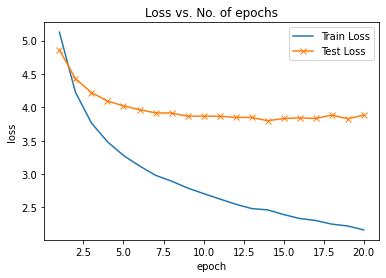

In [32]:
plt.plot(metrics['epoch'], metrics['Train Loss'], label="Train Loss")
plt.plot(metrics['epoch'], metrics['Valid Loss'], '-x', label="Test Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss vs. No. of epochs');

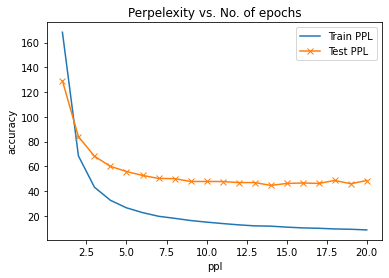

In [33]:
plt.plot(metrics['epoch'], metrics['Train PPL'], label="Train PPL")
plt.plot(metrics['epoch'], metrics['Valid PPL'], '-x', label="Test PPL")
plt.xlabel('ppl')
plt.ylabel('accuracy')
plt.legend()
plt.title('Perpelexity vs. No. of epochs');